In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
X_full_train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
X_full_test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [3]:
def create_total_bill(train):
    rs = 'RoomService'
    fc = 'FoodCourt'
    sm = 'ShoppingMall'
    spa = 'Spa'
    vrd = 'VRDeck'
    if train:
        total_bill = X_full_train[[rs, fc, sm, spa, vrd]].sum(axis=1)
        X_full_train.insert(12, 'TotalBill', total_bill)
    else:
        total_bill = X_full_test[[rs, fc, sm, spa, vrd]].sum(axis=1)
        X_full_test.insert(12, 'TotalBill', total_bill)

In [4]:
def split_train_cabin():
    deck = [str(c).split('/')[0] if c is not np.nan else 'nan' for c in X_full_train.Cabin]
    number = [str(c).split('/')[1] if c is not np.nan else 'nan' for c in X_full_train.Cabin]
    ps = [str(c).split('/')[2] if c is not np.nan else 'nan' for c in X_full_train.Cabin]
    X_full_train.insert(3, 'Deck', deck)
    X_full_train.insert(4, 'Number', number)
    X_full_train.insert(5, 'P/S', ps)
    X_full_train.drop(['Cabin'], axis=1, inplace=True)

In [5]:
# def split_test_cabin():
#     deck = [str(c).split('/')[0] if c is not np.nan else 'nan' for c in X_full_test.Cabin]
#     number = [str(c).split('/')[1] if c is not np.nan else 'nan' for c in X_full_test.Cabin]
#     ps = [str(c).split('/')[2] if c is not np.nan else 'nan' for c in X_full_test.Cabin]
#     X_full_test.insert(3, 'Deck', deck)
#     X_full_test.insert(4, 'Number', number)
#     X_full_test.insert(5, 'P/S', ps)
#     X_full_test.drop(['Cabin'], axis=1, inplace=True)

In [6]:
def change_types_train():
    X_full_train.CryoSleep = X_full_train.CryoSleep.astype(bool)
    X_full_train.VIP = X_full_train.VIP.astype(bool)
#     X_full_train.CryoSleep = pd.to_numeric(X_full_train.CryoSleep, errors='coerce')
#     X_full_train.VIP = pd.to_numeric(X_full_train.VIP, errors='coerce')
#     X_full_train.Number = pd.to_numeric(X_full_train.Number, errors='coerce')

In [7]:
# def change_types_test():
#     X_full_test.CryoSleep = X_full_test.CryoSleep.astype(bool)
#     X_full_test.VIP = X_full_test.VIP.astype(bool)
#     X_full_test.Number = pd.to_numeric(X_full_test.Number, errors='coerce')

In [8]:
def separate_cols_train():
    numerical_cols = [c for c in X_full_train.columns if X_full_train[c].dtype in ['float']]
    categorical_cols = [c for c in X_full_train.columns if X_full_train[c].dtype == 'object']
    boolean_cols = [c for c in X_full_train.columns if X_full_train[c].dtype == 'bool']
    my_cols = numerical_cols + categorical_cols + boolean_cols
    return my_cols

In [9]:
# def separate_cols_test():
#     numerical_cols = [c for c in X_full_test.columns if X_full_test[c].dtype in ['float']]
#     categorical_cols = [c for c in X_full_test.columns if X_full_test[c].dtype == 'object']

In [10]:
create_total_bill(True)
# create_total_bill(False)
split_train_cabin()
# split_test_cabin()
change_types_train()
# change_types_test()
# separate_cols_train()
# separate_cols_test()

<Axes: >

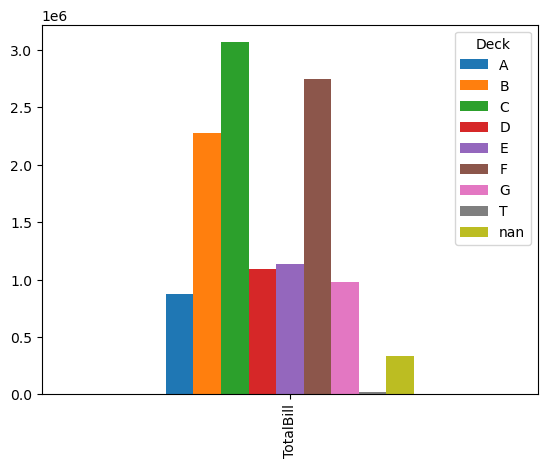

In [11]:
bill_per_deck = X_full_train[['Deck', 'TotalBill']].groupby('Deck').sum()
bill_per_deck.T.plot.bar()

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [13]:
y = X_full_train.Transported
X_full_train.drop('Transported', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X_full_train, y, test_size=0.2, random_state=0)

In [14]:
# Convert columns to integer type after handling missing values
X_train['CryoSleep'] = X_train['CryoSleep'].astype(float).fillna(0).astype(int)
X_train['VIP'] = X_train['VIP'].astype(float).fillna(0).astype(int)
X_train['Number'] = X_train['Number'].astype(float).fillna(0).astype(int)


In [15]:
X_train

,PassengerId,HomePlanet,CryoSleep,Deck,Number,P/S,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalBill,Name
4278,4558_01,Europa,0,C,167,S,55 Cancri e,54.0,0,0.0,559.0,0.0,15238.0,2799.0,18596.0,Wezna Baleful
5971,6326_01,Earth,0,F,1307,P,TRAPPIST-1e,20.0,0,0.0,20.0,1.0,696.0,0.0,717.0,Therek Hinetthews
464,0503_02,Mars,0,F,90,S,TRAPPIST-1e,43.0,0,1821.0,0.0,47.0,29.0,0.0,1897.0,Torms Fone
4475,4757_01,Earth,0,F,896,S,TRAPPIST-1e,24.0,0,185.0,0.0,476.0,1810.0,53.0,2524.0,Tanley Mirandry
8469,9046_01,Europa,1,C,335,S,55 Cancri e,25.0,0,0.0,0.0,0.0,0.0,0.0,0.0,Alphah Cratrave
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4373,4655_01,Europa,1,B,154,P,55 Cancri e,32.0,0,0.0,0.0,0.0,0.0,0.0,0.0,Ainkard Seflock
7891,8423_01,Earth,0,F,1620,S,TRAPPIST-1e,22.0,0,0.0,0.0,6.0,0.0,733.0,739.0,Analdy Bartez
4859,5185_01,Mars,0,E,330,S,TRAPPIST-1e,29.0,0,523.0,0.0,21.0,4.0,811.0,1359.0,Cruts Flie
3264,3499_04,Earth,0,G,574,P,TRAPPIST-1e,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,Allene Mccarveymon


In [16]:
X_train.isnull().sum().sum() / X_train.shape[0] * 100

19.787172850158182

<Axes: >

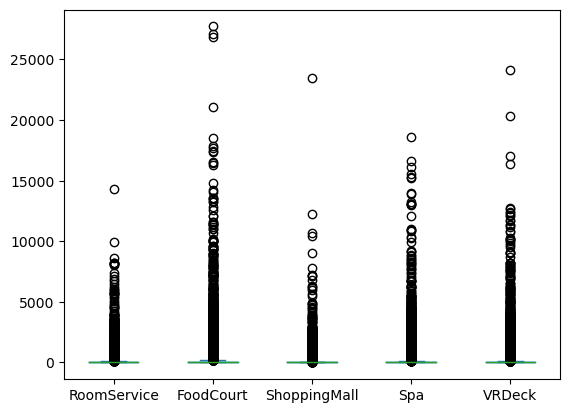

In [17]:
X_train.loc[:, 'RoomService':'VRDeck'].plot.box()

In [18]:
numerical_cols = [c for c in X_full_train.columns if X_full_train[c].dtype == 'float64']
categorical_cols = [c for c in X_full_train.columns if X_full_train[c].dtype == 'object']
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')
encoder = OneHotEncoder(handle_unknown='ignore')
categorical_transformer = Pipeline(steps=[
    ('imputer', categorical_imputer),
    ('encoder', encoder)
])
preprocessor = ColumnTransformer(transformers=[
    ('numerical_transformer', numerical_imputer, numerical_cols),
    ('categorical_transformer', categorical_transformer, categorical_cols)
])
preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
model = XGBClassifier(n_estimators=1000, learning_rate=0.05, random_state=0, eval_metric='logloss')
fit_params = {
    'model__eval_set': [(X_test_transformed, y_test)],
#     'model__eval_metric': 'logloss',
    'model__verbose': False
}
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', model)
])
pipeline.fit(X_train, y_train, **fit_params)
preds = pipeline.predict(X_test)
acc = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
f1 = f1_score(y_test, preds)
recall = recall_score(y_test, preds)
roc_auc = roc_auc_score(y_test, preds)
print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.7912593444508338
Precision: 0.779107725788901
Recall: 0.817351598173516
F1 Score: 0.7977715877437326
ROC AUC Score: 0.7910628211029804
